In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from shutil import copy
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
os.chdir('/home/austin/Downloads/Fire-vs-NoFire/')
if os.path.isdir('Training_sample/Fire') is False:
    os.makedirs('Training_sample/Fire')
    os.makedirs('Training_sample/No_Fire')
    os.makedirs('Test_sample/Fire')
    os.makedirs('Test_sample/No_Fire')
for each in ['Fire', 'No_Fire']:    

    for i in random.sample(glob.glob('Training/'+each+'/*'), 1000):
        copy(i, 'Training_sample/'+each+'/')
        
    for i in random.sample(glob.glob('Test/'+each+'/*'), 200):
        copy(i, 'Test_sample/'+each+'/')        

In [3]:
train_path = '/home/austin/Downloads/Fire-vs-NoFire/Training_sample/'
test_path = '/home/austin/Downloads/Fire-vs-NoFire/Test_sample'

In [12]:
image_generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input, validation_split=0.1) 

train_batches = image_generator.flow_from_directory(directory=train_path, target_size=(254,254), classes=['No_Fire', 'Fire'], batch_size=10, subset="training", class_mode='categorical')
valid_batches = image_generator.flow_from_directory(directory=train_path, target_size=(254,254), classes=['No_Fire', 'Fire'], batch_size=10, subset="validation", class_mode='categorical')
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(254,254), classes=['No_Fire', 'Fire'], batch_size=10, shuffle=False)

Found 1800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [13]:
imgs, labels = next(train_batches)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

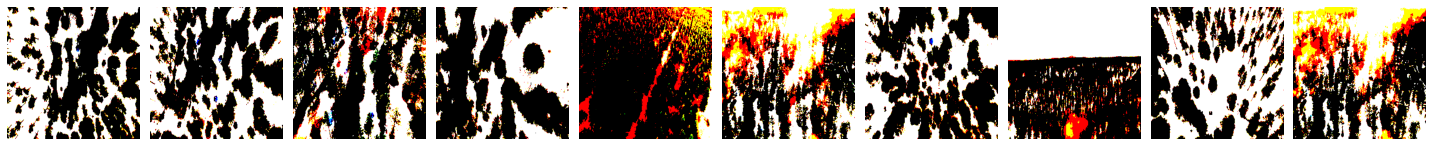

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [14]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
plotImages(imgs)
print(labels)

In [15]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(254,254,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='sigmoid')
])

In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 254016)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 508034    
Total params: 527,426
Trainable params: 527,426
Non-trainable params: 0
________________________________________________

In [17]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=5,
    verbose=2
)

Epoch 1/5
180/180 - 65s - loss: 4.2688 - accuracy: 0.9261 - val_loss: 7.6635 - val_accuracy: 0.7800
Epoch 2/5
180/180 - 77s - loss: 0.3519 - accuracy: 0.9867 - val_loss: 2.4047 - val_accuracy: 0.9550
Epoch 3/5
180/180 - 70s - loss: 0.0623 - accuracy: 0.9978 - val_loss: 3.8511 - val_accuracy: 0.8750
Epoch 4/5
180/180 - 71s - loss: 0.0613 - accuracy: 0.9989 - val_loss: 1.7508 - val_accuracy: 0.9550
Epoch 5/5
180/180 - 73s - loss: 0.0058 - accuracy: 1.0000 - val_loss: 1.8411 - val_accuracy: 0.9450


In [19]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [21]:
test_batches.class_indices

{'No_Fire': 0, 'Fire': 1}

Confusion matrix, without normalization
[[ 66 134]
 [ 64 136]]


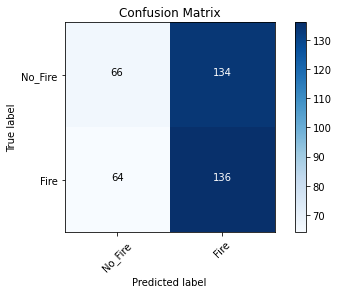

In [22]:
cm_plot_labels = ['No_Fire','Fire']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [23]:
accuracy_score(test_batches.classes, np.argmax(predictions, axis=-1))

0.505

In [ ]:
#vgg16_model = tf.keras.applications.vgg16.VGG16()

In [ ]:
# model_vgg = Sequential()
# for layer in vgg16_model.layers[:-1]:
#     model_vgg.add(layer)

In [ ]:
# model_vgg.add(Dense(units=2, activation='sigmoid'))

In [ ]:
# model_vgg.summary()

In [ ]:
# model_vgg.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# model_vggthta can .fit(x=train_batches,
#     steps_per_epoch=len(train_batches),
#     validation_data=valid_batches,
#     validation_steps=len(valid_batches),
#     epochs=5,
#     verbose=2
# )

In [ ]:
# predictions_vgg = model_vgg.predict(x=test_batches, steps=len(test_batches), verbose=0)
# cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions_vgg, axis=-1))

In [ ]:
# accuracy_score(test_batches.classes, np.argmax(predictions, axis=-1))